# Algorithme de reconnaissance d'image

In [272]:
#pip freeze > requirements.txt

In [271]:
#pip install -r requirements.txt

Processing c:\ci\aiohttp_1632750093640\work
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\ci\\aiohttp_1632750093640\\work'


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#pip install coremltools

     -------------------------------------- 882.2/882.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Created wheel for coremltools: filename=coremltools-6.1-py3-none-any.whl size=1181394 sha256=df65bb4cfeb46cdff85b6abbc8e05a6cee5ebc536aa94463669b84300e591751
  Stored in directory: c:\users\fifid\appdata\local\pip\cache\wheels\99\ee\ce\eefc6b284a2999bd688ec5663be3c2dc367a306cf23bb15d87
Successfully built coremltools


In [7]:
#pip install keras_preprocessing livelossplot


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Packages nécessaires

In [168]:
import os
import pandas as pd
import string
import random
import matplotlib
import numpy as np
#import coremltools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from keras import backend as K
from ast import literal_eval
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from livelossplot import PlotLossesKeras
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import PIL
import os
import os.path
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

# Caractéristiques du modèle

In [287]:
dir_images = 'Ressources_Test'
# Download dataset from https://www.kaggle.com/greg115/various-tagged-images
DATASET_PATH = dir_images +'\img_align_celeba\img_align_celeba' # Directory of the images with the following format "id-tag1_tag2.jpg"
METADATA_PATH = dir_images +'\list_attr_celeba.csv' #modif
SPLIT_PATH = dir_images +'\list_eval_partition.csv'
MODEL_PATH = "saved_model/cp.h5"
IMAGE_PATH_KEY = "image_path"
TAGS_PATH_KEY = "tags"
NB_SELECTED = 1000
#MODEL_PATH = r"C:\Users\fifid\Documents\GitHub\projet-integrateur\Notebook\image_tagger.hdf5"
IMAGE_SIZE = 224 # pas modif car sinon pb avec fully connected
BATCH_SIZE = 16 #nb d'images en entrée du réseau en même temps
#VALIDATION_SPLIT = 0.1 # a modif
RANDOM_SEED = 115
EPOCHS = 100 #combien de fois on visualise l'ensemble des images du dataset, au moins 100
DROPOUT = 0.3 #0.2 ou 0.3
FULLY_CONNECTED = 1024
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY = LEARNING_RATE/100.0
CONFIDENCE_THRESHOLD = 0.9
excluded_labels = ["Arched_Eyebrows","Attractive","Blurry","Double_Chin","Narrow_Eyes"]

# Resize des images

In [288]:
f = DATASET_PATH
for file in os.listdir(f):
    f_img = f+"/"+file
    img = Image.open(f_img)
    img = img.resize((224,224))
    img.save(f_img)

# Load les datas

On se sert des recommandations sur le dataset : 

    "Recommended partitioning of the images into training, validation, testing sets. "0" represents training image, "1" represents validation image, "2" represents testing image. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing"
    
On utilise le fichier indiquant la répartition pour splitter les données.

In [289]:
df_old = pd.read_csv(METADATA_PATH, nrows=NB_SELECTED)
split_df = pd.read_csv(SPLIT_PATH, nrows=NB_SELECTED)

In [290]:
#df_old

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,000996.jpg,-1,1,-1,-1,-1,1,-1,-1,-1,...,-1,1,-1,-1,1,-1,1,1,-1,-1
996,000997.jpg,-1,-1,1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,1,-1,1,-1,-1,-1
997,000998.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1
998,000999.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [291]:
#split_df

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0
...,...,...
995,000996.jpg,0
996,000997.jpg,0
997,000998.jpg,0
998,000999.jpg,0


# Optionnel : on change les répartitions Training/Testing/Validation

In [292]:
part = [0 if i<(len(split_df)*0.7) else (1 if (i>=(len(split_df)*0.7) and i<len(split_df)*0.8) else 2) for i in range(len(split_df))]

split_df = pd.DataFrame(list(zip(list(split_data[split_data.columns[0]]), part)),
               columns =['image_path', split_data.columns[1]])

In [293]:
#split_df

,image_path,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0
...,...,...
995,000996.jpg,2
996,000997.jpg,2
997,000998.jpg,2
998,000999.jpg,2


# Récupération des labels pour chaque image et mise en forme du dataframe

Pour chaque image on fait une liste des labels qui lui sont attribués. Dans une liste on stocke tout les labels qui sont à 1 pour cette image.

In [294]:
y = []
for row in df_old.iterrows():
    sub_y = []
    for i in range(1,len(row[1])) :
        if (int(row[1][i])==1) and (df_old.columns.values[i] not in excluded_labels):
            sub_y.append(df_old.columns.values[i])
    y.append(sub_y)
    
df = pd.DataFrame(list(zip(list(df_old[df_old.columns[0]]), y)),
               columns =['image_path', 'tags'])

#on merge la répartion des images et leurs labels dans le même dataset
result = pd.merge(split_df, df,on='image_path')

In [295]:
#df

,image_path,tags
0,000001.jpg,"[Brown_Hair, Heavy_Makeup, High_Cheekbones, Mo..."
1,000002.jpg,"[Bags_Under_Eyes, Big_Nose, Brown_Hair, High_C..."
2,000003.jpg,"[Big_Lips, Male, No_Beard, Pointy_Nose, Wavy_H..."
3,000004.jpg,"[No_Beard, Pointy_Nose, Straight_Hair, Wearing..."
4,000005.jpg,"[Big_Lips, Heavy_Makeup, No_Beard, Pointy_Nose..."
...,...,...
995,000996.jpg,"[Bangs, Blond_Hair, Heavy_Makeup, High_Cheekbo..."
996,000997.jpg,"[Bangs, Blond_Hair, Heavy_Makeup, No_Beard, Pa..."
997,000998.jpg,"[Blond_Hair, Heavy_Makeup, Mouth_Slightly_Open..."
998,000999.jpg,"[Male, No_Beard]"


In [296]:
#result

,image_path,partition,tags
0,000001.jpg,0,"[Brown_Hair, Heavy_Makeup, High_Cheekbones, Mo..."
1,000002.jpg,0,"[Bags_Under_Eyes, Big_Nose, Brown_Hair, High_C..."
2,000003.jpg,0,"[Big_Lips, Male, No_Beard, Pointy_Nose, Wavy_H..."
3,000004.jpg,0,"[No_Beard, Pointy_Nose, Straight_Hair, Wearing..."
4,000005.jpg,0,"[Big_Lips, Heavy_Makeup, No_Beard, Pointy_Nose..."
...,...,...,...
995,000996.jpg,2,"[Bangs, Blond_Hair, Heavy_Makeup, High_Cheekbo..."
996,000997.jpg,2,"[Bangs, Blond_Hair, Heavy_Makeup, No_Beard, Pa..."
997,000998.jpg,2,"[Blond_Hair, Heavy_Makeup, Mouth_Slightly_Open..."
998,000999.jpg,2,"[Male, No_Beard]"


# Split des data

In [297]:
training_df = result.loc[result['partition']==0]
validation_df = result.loc[result['partition']==1]
testing_df = result.loc[result['partition']==2]
TESTING_SIZE = len(testing_df)

In [298]:
#training_df

,image_path,partition,tags
0,000001.jpg,0,"[Brown_Hair, Heavy_Makeup, High_Cheekbones, Mo..."
1,000002.jpg,0,"[Bags_Under_Eyes, Big_Nose, Brown_Hair, High_C..."
2,000003.jpg,0,"[Big_Lips, Male, No_Beard, Pointy_Nose, Wavy_H..."
3,000004.jpg,0,"[No_Beard, Pointy_Nose, Straight_Hair, Wearing..."
4,000005.jpg,0,"[Big_Lips, Heavy_Makeup, No_Beard, Pointy_Nose..."
...,...,...,...
695,000696.jpg,0,"[Male, No_Beard, Oval_Face, Smiling, Young]"
696,000697.jpg,0,"[Bags_Under_Eyes, Bangs, Big_Nose, High_Cheekb..."
697,000698.jpg,0,"[Heavy_Makeup, High_Cheekbones, Mouth_Slightly..."
698,000699.jpg,0,"[Blond_Hair, Heavy_Makeup, No_Beard, Oval_Face..."


In [299]:
#validation_df

,image_path,partition,tags
700,000701.jpg,1,"[Heavy_Makeup, High_Cheekbones, No_Beard, Oval..."
701,000702.jpg,1,"[Big_Lips, Blond_Hair, Heavy_Makeup, Mouth_Sli..."
702,000703.jpg,1,"[Big_Lips, Big_Nose, Heavy_Makeup, High_Cheekb..."
703,000704.jpg,1,"[Big_Lips, No_Beard, Pale_Skin, Pointy_Nose, S..."
704,000705.jpg,1,"[Brown_Hair, Eyeglasses, Male, No_Beard, Young]"
...,...,...,...
795,000796.jpg,1,"[Brown_Hair, Heavy_Makeup, High_Cheekbones, Mo..."
796,000797.jpg,1,"[Bags_Under_Eyes, Big_Nose, Brown_Hair, Bushy_..."
797,000798.jpg,1,"[Bags_Under_Eyes, Bangs, Big_Nose, Chubby, Eye..."
798,000799.jpg,1,"[Big_Lips, Heavy_Makeup, High_Cheekbones, No_B..."


In [300]:
#testing_df

,image_path,partition,tags
800,000801.jpg,2,"[5_o_Clock_Shadow, Bags_Under_Eyes, Big_Lips, ..."
801,000802.jpg,2,"[Mouth_Slightly_Open, No_Beard, Smiling, Young]"
802,000803.jpg,2,"[High_Cheekbones, Male, No_Beard, Young]"
803,000804.jpg,2,"[Blond_Hair, Heavy_Makeup, High_Cheekbones, Mo..."
804,000805.jpg,2,"[Big_Lips, No_Beard, Pointy_Nose, Straight_Hai..."
...,...,...,...
995,000996.jpg,2,"[Bangs, Blond_Hair, Heavy_Makeup, High_Cheekbo..."
996,000997.jpg,2,"[Bangs, Blond_Hair, Heavy_Makeup, No_Beard, Pa..."
997,000998.jpg,2,"[Blond_Hair, Heavy_Makeup, Mouth_Slightly_Open..."
998,000999.jpg,2,"[Male, No_Beard]"


# Récupération de la liste des labels possibles 

In [301]:
all_labels = [] 
for labels in training_df[TAGS_PATH_KEY].values.tolist():
    for label in labels:
        all_labels.append(label)
        
unique_labels = list(np.unique(all_labels))

In [302]:
#unique_labels

['5_o_Clock_Shadow',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

# Mise en forme et splitting 

In [303]:
training_data_generator = ImageDataGenerator(rotation_range=30,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             shear_range=0.2,
                                             horizontal_flip=True,
                                             fill_mode="nearest",
                                             preprocessing_function=preprocess_input)

print("Training :")
training_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                 directory=DATASET_PATH,
                                                                 x_col=IMAGE_PATH_KEY, 
                                                                 y_col=TAGS_PATH_KEY,
                                                                 batch_size=BATCH_SIZE,
                                                                 seed=RANDOM_SEED,
                                                                 class_mode="categorical",
                                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                 )
print("Validation :")
validation_generator = training_data_generator.flow_from_dataframe(dataframe=validation_df,
                                                                   directory=DATASET_PATH,
                                                                   x_col=IMAGE_PATH_KEY,
                                                                   y_col=TAGS_PATH_KEY,
                                                                   batch_size=BATCH_SIZE,
                                                                   seed=RANDOM_SEED,
                                                                   class_mode="categorical",
                                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                                   )
print("Testing :")
testing_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
testing_generator = testing_data_generator.flow_from_dataframe(dataframe=testing_df,
                                                               directory=DATASET_PATH,
                                                               x_col=IMAGE_PATH_KEY,
                                                               batch_size=1,
                                                               seed=RANDOM_SEED,
                                                               shuffle=False,
                                                               class_mode=None,
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE))


Training :
Found 700 validated image filenames belonging to 35 classes.
Validation :
Found 100 validated image filenames belonging to 35 classes.
Testing :
Found 200 validated image filenames.


# Fonctions d'évaluation

In [304]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p++K.epsilon()))

# Définition et construction du modèle

In [305]:
def get_model():
    def model(backbone):
        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(Dropout(DROPOUT))
        model.add(BatchNormalization())
        model.add(Dense(FULLY_CONNECTED, activation='relu'))
        model.add(Dense(len(unique_labels), activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.Adam(lr=LEARNING_RATE, decay=LEARNING_RATE_DECAY),
                      metrics=["accuracy", recall, precision, f1])
        return model

    backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
    backbone.trainable = False
    return model(backbone)

model = get_model()

C:\Users\fifid\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Enregistrement du modèle

In [306]:
checkpoint_dir = os.path.dirname(MODEL_PATH)
cp_callback = ModelCheckpoint(filepath=MODEL_PATH,
                               monitor='val_f1',
                               mode='max',
                               save_best_only=True, verbose=1)

# Entrainement du modèle

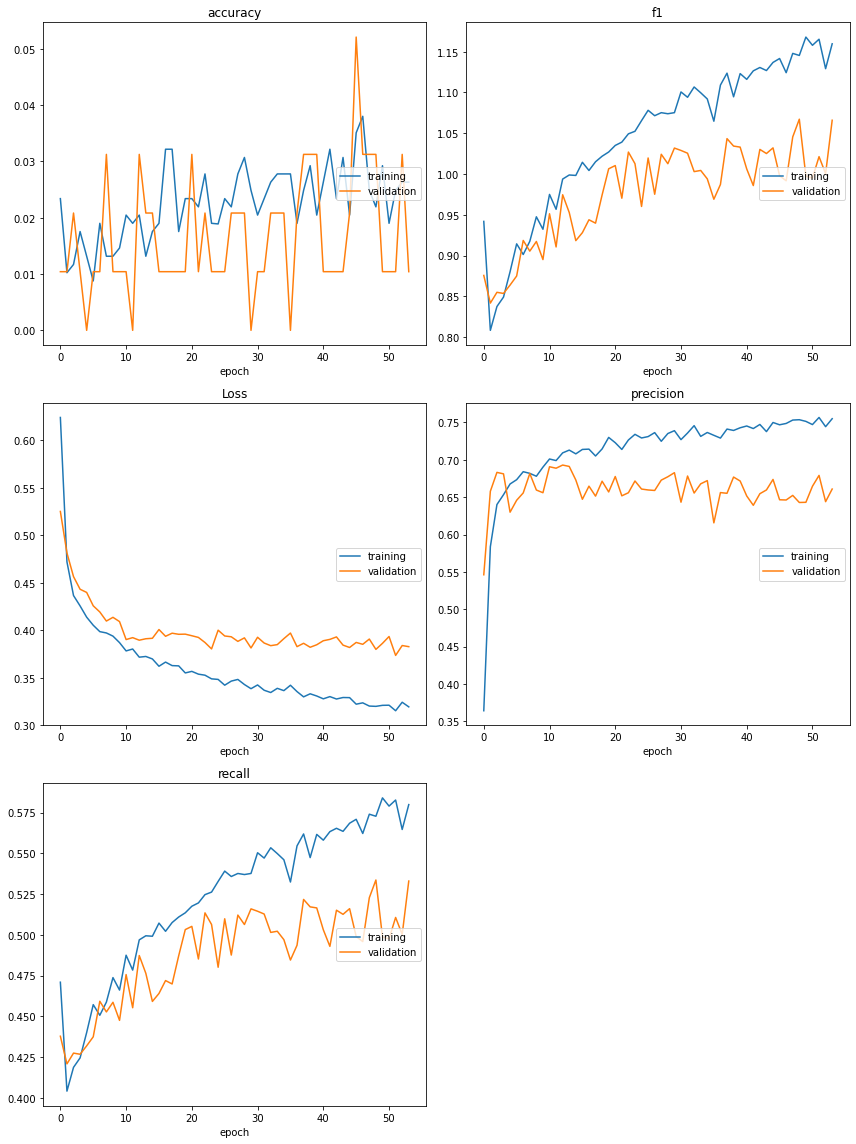

accuracy
	training         	 (min:    0.009, max:    0.038, cur:    0.026)
	validation       	 (min:    0.000, max:    0.052, cur:    0.010)
f1
	training         	 (min:    0.808, max:    1.168, cur:    1.160)
	validation       	 (min:    0.842, max:    1.067, cur:    1.066)
Loss
	training         	 (min:    0.315, max:    0.624, cur:    0.319)
	validation       	 (min:    0.374, max:    0.525, cur:    0.383)
precision
	training         	 (min:    0.364, max:    0.757, cur:    0.755)
	validation       	 (min:    0.546, max:    0.693, cur:    0.661)
recall
	training         	 (min:    0.404, max:    0.584, cur:    0.580)
	validation       	 (min:    0.421, max:    0.534, cur:    0.533)

Epoch 54: val_f1 did not improve from 1.06723
43/43 [==============================] - 13s 297ms/step - loss: 0.3194 - accuracy: 0.0263 - recall: 0.5799 - precision: 0.7550 - f1: 1.1597 - val_loss: 0.3827 - val_accuracy: 0.0104 - val_recall: 0.5330 - val_precision: 0.6609 - val_f1: 1.0659
Epoch 55/100
29

KeyboardInterrupt: 

In [307]:
model.fit(x=training_generator,
            steps_per_epoch=training_generator.n // training_generator.batch_size,
            validation_data=validation_generator,
            validation_steps=validation_generator.n // validation_generator.batch_size,
            callbacks=[PlotLossesKeras(),cp_callback],
            epochs=EPOCHS)


# Vérification de l'enregistrement du modèle

In [250]:
os.listdir(checkpoint_dir)

['cp.h5']

In [251]:
model = load_model(MODEL_PATH, custom_objects={"f1": f1, "recall": recall,"precision": precision})

# Calcul des prédictions du modèle sur les données de test

In [252]:
predictions = model.predict(testing_generator,
                              steps=TESTING_SIZE,
                              verbose=1)

200/200 [==============================] - 11s 48ms/step


# Mise en forme des prédictions

In [258]:
images_path = []
predicted_titles = []
pred_labels = []

seuil_confiance = 40

for prediction_index, prediction in enumerate(predictions):
    predicted_title = []
    for i in range(len(prediction)):
        if prediction[i]*100 >seuil_confiance :
            predicted_title.append(unique_labels[i] + " %.1f" % (prediction[i]*100) + "%")
            pred_labels.append(unique_labels[i])
    images_path.append(testing_generator.filenames[prediction_index])
    predicted_titles.append(title)

In [259]:
def difference(index) : 
    line = df_old.loc[df_old['image_id'] == images_path[index]]
    sub_y = []
    for i in line.columns[1:] :
        sub_y.append(line[i].values[0])
    
    pred_y = [-1]*len(sub_y)
    for j in range(len(unique_labels)) :
        if unique_labels[j] in pred_labels[index]:
            pred_y[j] = 1
            
    drop_features = []
    correctness = 0
    for i in range(len(unique_labels)) :
        if sub_y[i] == pred_y[i]:
            correctness += 1
            drop_features.append(0)
        else :
            drop_features.append(1)
            
    correctness = correctness*100 / len(pred_y)
    return correctness, drop_features

# Calcul de proximité et d'influence

In [260]:
accuracy = 0
drop_features = {j:0 for j in unique_labels}

for i in range(len(images_path)):
    test = difference(i)
    for feat in range(len(test[1])):
        drop_features[unique_labels[feat]]+=test[1][feat]
    accuracy += test[0]

# Proximité et influence des labels

In [261]:
print("Proximité moyenne avec les labels réels : ",accuracy/len(images_path),"%")
print("Labels et le nombre de fois où ils étaient faux : ", dict(sorted(drop_features.items(), key=lambda item: item[1], reverse=True)))
#regarder quelles sont les features qui font chuter le plus (les plus subjectives)

Proximité moyenne avec les labels réels :  67.4125 %
Labels et le nombre de fois où ils étaient faux :  {'Rosy_Cheeks': 171, 'Wearing_Lipstick': 104, 'Bald': 97, 'No_Beard': 96, 'Pale_Skin': 93, 'Oval_Face': 86, 'Mustache': 71, 'Wearing_Necktie': 58, 'Straight_Hair': 55, 'Blond_Hair': 52, 'Sideburns': 51, 'Bags_Under_Eyes': 50, 'Young': 50, 'Black_Hair': 44, 'Big_Nose': 43, 'Wearing_Necklace': 43, 'Bangs': 42, 'Brown_Hair': 42, 'Bushy_Eyebrows': 35, 'Eyeglasses': 33, 'Mouth_Slightly_Open': 32, '5_o_Clock_Shadow': 27, 'Goatee': 25, 'Male': 25, 'Receding_Hairline': 25, 'Smiling': 25, 'Wavy_Hair': 23, 'High_Cheekbones': 22, 'Heavy_Makeup': 18, 'Wearing_Earrings': 17, 'Chubby': 14, 'Pointy_Nose': 11, 'Wearing_Hat': 10, 'Gray_Hair': 9, 'Big_Lips': 8}


# Test sur un dossier avec des images personnelles

In [262]:
"""
f = "test"
for files in os.listdir(f):
    f_img = f+"/"+files
    img = Image.open(f_img)
    img = img.resize((224,224))
    img.save(f_img)
print("Images resized !")
"""

Images resized !


In [263]:
"""
predictions =  []
images_path = []
labels_images = []
best_labels = []
seuil_confiance = 40

for file in os.listdir(f):
    f_img = f+"/"+file
    
    #load image
    my_image = load_img(f_img, target_size=(224, 224))

    #preprocess the image
    my_image = img_to_array(my_image)
    my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
    my_image = preprocess_input(my_image)
    
    #make the prediction
    pred_values = model.predict(my_image)
    predictions.append(pred_values)
    images_path.append(file)
    
    #enregistre les meilleurs labels
    best = []
    labels = []
    
    for i in range(len(pred_values[0])):
        if pred_values[0][i]*100 > seuil_confiance :
            best.append(unique_labels[i] + " %.1f" % (pred_values[0][i]*100) + "%")

        labels.append(unique_labels[i] + " %.1f" % (pred_values[0][i]*100) + "%")
        
    best_labels.append(best)
    labels_images.append(labels)
"""      

1/1 [==============================] - 0s 106ms/step


In [264]:
"""
for image in range(len(images_path)):  
    print(images_path[image])
    print("Best labels : ")
    print(best_labels[image])
"""

emma_test.jpg
Best labels : 
['Brown_Hair 42.0%', 'Heavy_Makeup 92.9%', 'High_Cheekbones 76.5%', 'Mouth_Slightly_Open 79.1%', 'No_Beard 98.3%', 'Smiling 57.2%', 'Wavy_Hair 63.0%', 'Wearing_Earrings 75.9%', 'Wearing_Lipstick 97.4%', 'Wearing_Necklace 46.5%', 'Young 79.9%']
matthis_test.jpg
Best labels : 
['5_o_Clock_Shadow 41.0%', 'Big_Nose 68.1%', 'Black_Hair 70.0%', 'Male 86.5%', 'No_Beard 42.7%', 'Oval_Face 46.3%', 'Smiling 54.6%', 'Young 63.5%']
